# Importar bibliotecas necesarias

In [1]:
import sys
import os
import importlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from pathlib import Path

### Se crea una funcion para modularizar el código guardado en scripts para facilitar su uso

In [2]:
# Ruta base del proyecto
base_dir = Path.cwd().parents[0] 

#Creacion de las variables de path para los scripts
data_path = os.path.join(base_dir,"DNN_Music", 'docs', 'data', 'musicdataset.csv')


# Función para importar y ejecutar scripts
def run_script(script_path):
    """Ejecutar el script especificado"""
    sys.path.append(os.path.dirname(script_path))
    script_name = os.path.basename(script_path).replace('.py', '')
    module = importlib.import_module(script_name)

    # Codigo que llama las funciones modularizadas
    if hasattr(module, 'load_data_set'):
        df, descriptions = module.load_data_set(data_path)
        return df, descriptions  
    else:
        return module

# 1. Adquisición de los datos

In [3]:
df, descriptions = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'data_acquisition', 'data_acquisition.py'))
print(df)

Ruta actual: a:\Users\arell\Desktop\ProyectoFinal\DNN_Music
Data set cargado con exito  y diccionario de descripciones creado
               filename  length  chroma_stft_mean  chroma_stft_var  rms_mean  \
0     blues.00000.0.wav   66149          0.335406         0.091048  0.130405   
1     blues.00000.1.wav   66149          0.343065         0.086147  0.112699   
2     blues.00000.2.wav   66149          0.346815         0.092243  0.132003   
3     blues.00000.3.wav   66149          0.363639         0.086856  0.132565   
4     blues.00000.4.wav   66149          0.335579         0.088129  0.143289   
...                 ...     ...               ...              ...       ...   
9985   rock.00099.5.wav   66149          0.349126         0.080515  0.050019   
9986   rock.00099.6.wav   66149          0.372564         0.082626  0.057897   
9987   rock.00099.7.wav   66149          0.347481         0.089019  0.052403   
9988   rock.00099.8.wav   66149          0.387527         0.084815  0.0664

### Limpieza inicial de los datos, eliminamos las columnas de 'filename' y 'length', se recibe el modulo de preprocesamiento para poder usar las funciones individuales

In [4]:
prepro_module = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'preprocessing', 'preprocessing.py'))
df_clean = prepro_module.clean_df(df)
print(df_clean)

      chroma_stft_mean  chroma_stft_var  rms_mean   rms_var  \
0             0.335406         0.091048  0.130405  0.003521   
1             0.343065         0.086147  0.112699  0.001450   
2             0.346815         0.092243  0.132003  0.004620   
3             0.363639         0.086856  0.132565  0.002448   
4             0.335579         0.088129  0.143289  0.001701   
...                ...              ...       ...       ...   
9985          0.349126         0.080515  0.050019  0.000097   
9986          0.372564         0.082626  0.057897  0.000088   
9987          0.347481         0.089019  0.052403  0.000701   
9988          0.387527         0.084815  0.066430  0.000320   
9989          0.369293         0.086759  0.050524  0.000067   

      spectral_centroid_mean  spectral_centroid_var  spectral_bandwidth_mean  \
0                1773.065032          167541.630869              1972.744388   
1                1816.693777           90525.690866              2010.051501   
2  

# 2. Analisis exploratorio de los datos

In [5]:
eda_module = run_script(os.path.join(base_dir,"DNN_Music", 'scripts', 'eda', 'eda.py'))

### Dimensiones del Dataframe

In [6]:
eda_module.df_shape(df_clean)


El dataset que vamos a utilizar tiene las dimensiones (9990, 58).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 58 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   chroma_stft_mean         9990 non-null   float64
 1   chroma_stft_var          9990 non-null   float64
 2   rms_mean                 9990 non-null   float64
 3   rms_var                  9990 non-null   float64
 4   spectral_centroid_mean   9990 non-null   float64
 5   spectral_centroid_var    9990 non-null   float64
 6   spectral_bandwidth_mean  9990 non-null   float64
 7   spectral_bandwidth_var   9990 non-null   float64
 8   rolloff_mean             9990 non-null   float64
 9   rolloff_var              9990 non-null   float64
 10  zero_crossing_rate_mean  9990 non-null   float64
 11  zero_crossing_rate_var   9990 non-null   float64
 12  harmony_mean             9990 non-null   float64
 13  harmony_var

### Memoria en uso del df

In [7]:
eda_module.memory_usage(df_clean)

Este dataset tiene un tamaño de 4.862802505493164 MB.


### ¿En qué formato están guardados los datos?

In [8]:
eda_module.data_type(df_clean)

Los tipos de datos en el dataframe son:

float64    57
object      1
Name: count, dtype: int64.


### Hay datos faltantes en el DataFrame?

In [9]:
eda_module.missing_data(df_clean)

chroma_stft_mean           0
chroma_stft_var            0
rms_mean                   0
rms_var                    0
spectral_centroid_mean     0
spectral_centroid_var      0
spectral_bandwidth_mean    0
spectral_bandwidth_var     0
rolloff_mean               0
rolloff_var                0
zero_crossing_rate_mean    0
zero_crossing_rate_var     0
harmony_mean               0
harmony_var                0
perceptr_mean              0
perceptr_var               0
tempo                      0
mfcc1_mean                 0
mfcc1_var                  0
mfcc2_mean                 0
mfcc2_var                  0
mfcc3_mean                 0
mfcc3_var                  0
mfcc4_mean                 0
mfcc4_var                  0
mfcc5_mean                 0
mfcc5_var                  0
mfcc6_mean                 0
mfcc6_var                  0
mfcc7_mean                 0
mfcc7_var                  0
mfcc8_mean                 0
mfcc8_var                  0
mfcc9_mean                 0
mfcc9_var     

### Podemos ver que no hay ningún dato faltante en el dataset seleccionado.

## *Visualización de las labels en el df y su distribución en los géneros músicales*

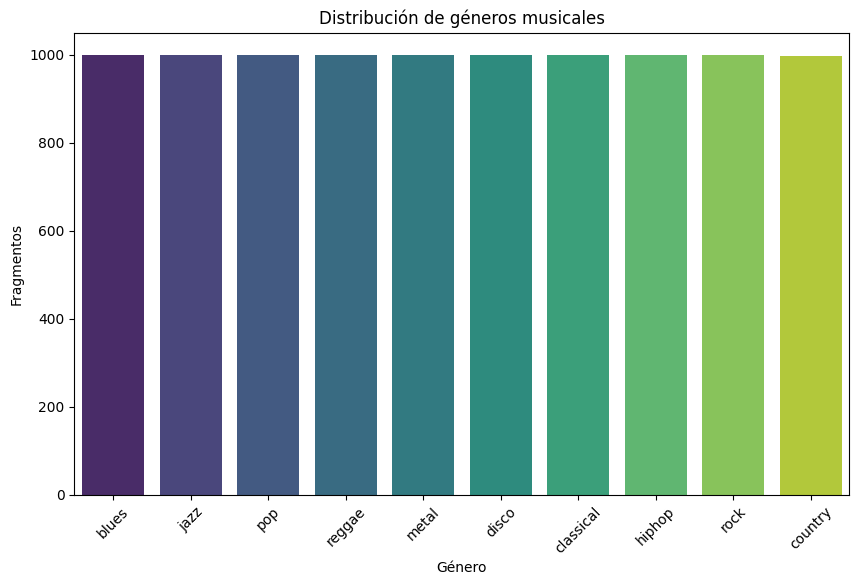

In [10]:
eda_module.label_visualizer(df_clean)